In [94]:
import numpy as np
import math
from scipy.stats import norm
from matplotlib import pyplot as plt
from numpy import linalg as LA
from scipy.stats import unitary_group
from scipy.integrate import quad
import random
# import concurrent.futures
import multiprocessing
import os
from scipy import stats

from mpl_toolkits import mplot3d
import scipy.integrate as spi

In [95]:
rho_a =1
rho_q=1
M =1
def MSE_zertothresh_analytic(sigma1,sigma2, n_a,n_q):
    alpha = (2 / math.pi) * math.acos(rho_q / (rho_q + pow(sigma2, 2)))
    beta = ((1-alpha)/rho_q)-((2*rho_a*n_a)/(math.pi*(rho_q+pow(sigma2,2))*(rho_a*n_a+pow(sigma1,2))))
    first = (rho_a*n_a)/(rho_a*n_a+pow(sigma1, 2))
    second = (2*rho_q*n_q*pow(sigma1,4))/(math.pi*(rho_q+pow(sigma2, 2))*(alpha+beta*rho_q*n_q)*pow(rho_a*n_a+pow(sigma1, 2),2))
    return M*(1-first-second)

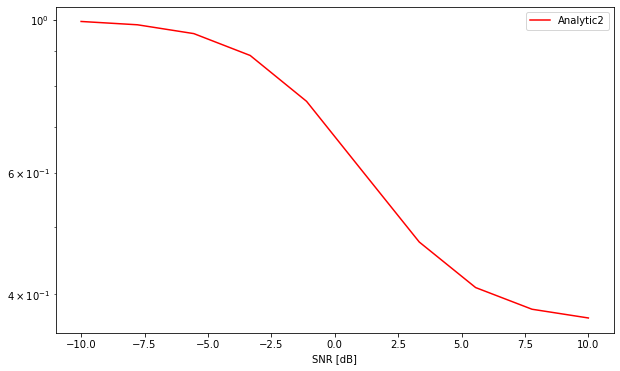

In [96]:
na = 0
nq = 1
sigma_space_new = np.logspace(-1,1,10)

L_Estimator_analytic = [MSE_zertothresh_analytic(sigma_space_new[i],sigma_space_new[i], na, nq) for i in range(len(sigma_space_new))]
######################
fig = plt.figure(figsize=(10, 6))
plt.plot(10*np.log10(1/sigma_space_new), L_Estimator_analytic, color = "red", label = "Analytic2")
plt.yscale('log')
plt.xlabel("SNR [dB]")
plt.legend()
plt.show()

In [97]:
def samp_teta(observ): #samples-for CRB function (d_k)
    teta_samp = np.random.normal(0, 1, (M, observ))
    return  teta_samp.reshape(M,observ)

def CRB(sigma1,sigma2, n_a,n_q,observ=100,thresh_real=0,thresh_im=0):
    teta_samp = samp_teta(observ)
    g_teta = teta_samp
    zeta_real = ((1/sigma2)*(g_teta.real-thresh_real))
    pdf_real = norm.pdf(zeta_real)
    d_vec = np.divide(np.power(pdf_real, 2), np.multiply(norm.cdf(zeta_real), (norm.cdf(-zeta_real))))
    d = np.mean(d_vec, axis=1) #converges to 0.95 aprox.
    J2 = np.sum(d,axis=0)*(1/(pow(sigma2, 2)))
    J1 = (1 + (rho_a * n_a/ pow(sigma1, 2))) * np.identity(M)
    J = J1 + J2
    return LA.norm((LA.inv(J)).real,"fro")

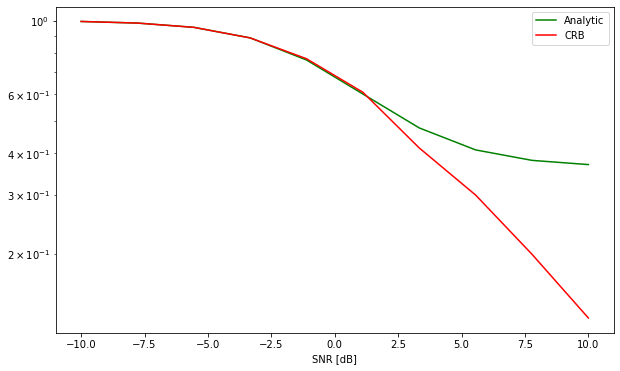

In [98]:
na = 0
nq = 1
sigma_space_new = np.logspace(-1, 1, 10)
L_Estimator_analytic1 = [MSE_zertothresh_analytic(sigma_space_new[i],sigma_space_new[i], na,nq) for i in range(len(sigma_space_new))]
CRB1 = [CRB(sigma_space_new[i],sigma_space_new[i],na,nq) for i in range(len(sigma_space_new))]
######################
fig = plt.figure(figsize=(10, 6))
plt.plot(10*np.log10(1/sigma_space_new), L_Estimator_analytic1, color = "green", label = "Analytic")
plt.plot(10*np.log10(1/sigma_space_new), CRB1, color = "red", label = "CRB")
plt.yscale('log')
plt.xlabel("SNR [dB]")
plt.legend()
plt.show()

In [99]:
def inner(theta,sigma2,s,h,thresh_real=0):
    return pow(norm.cdf((1/sigma2)*((theta+h)-thresh_real)),s)*\
    pow(norm.cdf((1/sigma2)*((theta)-thresh_real)),1-s)+\
    pow(norm.cdf(-(1/sigma2)*((theta+h)-thresh_real)),s)*\
    pow(norm.cdf(-(1/sigma2)*((theta)-thresh_real)),1-s)#+\
    # pow(norm.cdf(-(1/sigma2)*((theta+h)-thresh_real)),s)*\
    # pow(norm.cdf((1/sigma2)*((theta)-thresh_real)),1-s)+\
    # pow(norm.cdf((1/sigma2)*((theta+h)-thresh_real)),s)*\
    # pow(norm.cdf(-(1/sigma2)*((theta)-thresh_real)),1-s)

In [100]:
def ratio_func(theta,sigma2,s,h):
    return pow(1/(math.sqrt(2*math.pi))*math.exp(-0.5*((theta+h)**2)),s)*pow(1/(math.sqrt(2*math.pi))*math.exp(-0.5*(theta**2)),1-s)*inner(theta,sigma2,s,h)
def etha(sigma2,s,h):
    expected_value, _ = quad(ratio_func,-10, 10, args=(sigma2,s,h))
    return math.log(expected_value)
def WWS(sigma2,s,h):
    return (h**2)*(math.e**(2*etha(sigma2,s,h)))/(2*(1-math.e**(etha(sigma2,s,2*h))))

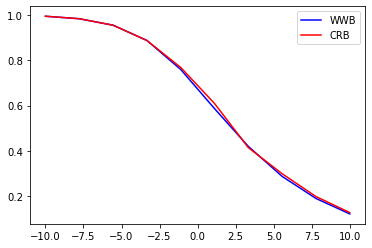

In [104]:
s= 0.5
h= 0.00001
sigma_space_new = np.logspace(-1, 1, 10)
WWS1 = [WWS(sigma_space_new[i],s,h) for i in range(len(sigma_space_new))]
plt.plot(10*np.log10(1/sigma_space_new), WWS1, color = "blue", label = "WWB")
plt.plot(10*np.log10(1/sigma_space_new), CRB1, color = "red", label = "CRB")
plt.legend()